In [2]:
# Section 1: Setup & Data Loading

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime

# -----------------------------------------------------------------------------
# 1.1. Constants & Hyper-parameters
# -----------------------------------------------------------------------------
BASE_DIR = "/Users/akv020/Tensorflow/fennomag-net/source/model2024/data"
TARGET_CSV = os.path.join(BASE_DIR, "target.csv")
GEODATA_CSV = os.path.join(BASE_DIR, "geodata.csv")
SECS_DATA_NPY = os.path.join(BASE_DIR, "secs_data.npy")
SECS_TS_NPY = os.path.join(BASE_DIR, "secs_timestamps.npy")

HORIZON_MINUTES = 15          # forecast horizon in minutes
BRANCH1_WINDOW_STEPS = 96     # 24h at 15-min intervals
BRANCH2_WINDOW_STEPS = 180    # 3h at 1-min intervals
BATCH_SIZE = 64

# -----------------------------------------------------------------------------
# 1.2. Load and Inspect Data
# -----------------------------------------------------------------------------
# Load target magnetic field components
target_df = pd.read_csv(
    TARGET_CSV,
    parse_dates=["DateTime"],
    index_col="DateTime"
)
print(f"Target data: {target_df.shape} rows")

# Load Branch 1 geophysical time series
geo_df = pd.read_csv(
    GEODATA_CSV,
    parse_dates=["DateTime"],
    index_col="DateTime"
)
print(f"Geophysical data: {geo_df.shape} rows, {geo_df.shape[1]} features")

# Load Branch 2 SECS image data and timestamps
secs_data = np.load(SECS_DATA_NPY)         # shape (n_obs, 21,21,3)
secs_timestamps = np.load(SECS_TS_NPY)     # shape (n_obs,)
secs_index = pd.to_datetime(secs_timestamps)
print(f"SECS data array: {secs_data.shape}")

# Sanity checks
assert target_df.index.is_monotonic_increasing, "Target times not sorted!"
assert geo_df.index.is_monotonic_increasing,   "Geo data times not sorted!"
assert np.all(np.diff(secs_index.values) > np.timedelta64(0, 'ns')), \
       "SECS timestamps not sorted!"
print("Data loaded and indices sorted.")



Target data: (527040, 3) rows
Geophysical data: (35136, 22) rows, 22 features
SECS data array: (527040, 21, 21, 3)
Data loaded and indices sorted.


In [3]:
# Section 2: Preprocessing Branch 1 (with full time tracking)
# -----------------------------------------------------------------------------
def create_branch1_windows(geo_df, target_df, window_size, horizon_minutes):
    """
    Builds lookback windows of geophysical features and targets,
    tracking window start, end, and prediction times.
    """
    step = 15
    horizon_steps = horizon_minutes // step
    X_list, y_list = [], []
    times_start1, times_end1, times_target = [], [], []

    max_end = len(geo_df) - horizon_steps
    for end_idx in range(window_size - 1, max_end):
        start_idx = end_idx - window_size + 1
        t_start = geo_df.index[start_idx]
        t_end   = geo_df.index[end_idx]
        t_pred  = t_end + pd.Timedelta(minutes=horizon_minutes)

        if t_pred in target_df.index:
            X_list.append(geo_df.iloc[start_idx:end_idx+1].values)
            y_list.append(target_df.loc[t_pred].values)
            times_start1.append(t_start)
            times_end1.append(t_end)
            times_target.append(t_pred)

    X1 = np.stack(X_list, axis=0)
    y  = np.stack(y_list, axis=0)
    return X1, y, times_start1, times_end1, times_target

# Execute Branch 1 window creation
X1_all, y_all, times_start1, times_end1, times_target = create_branch1_windows(
    geo_df, target_df,
    BRANCH1_WINDOW_STEPS, HORIZON_MINUTES
)
print(f"Branch1 samples: {X1_all.shape[0]}")
print("First window start:", times_start1[0])
print("First window end:  ", times_end1[0])
print("First prediction:   ", times_target[0])

# Chronological train/val/test split
n_total = X1_all.shape[0]
n_train = int(n_total * 0.70)
n_val   = int(n_total * 0.15)

X1_train = X1_all[:n_train]
X1_val   = X1_all[n_train:n_train+n_val]
X1_test  = X1_all[n_train+n_val:]
y_train  = y_all[:n_train]
y_val    = y_all[n_train:n_train+n_val]
y_test   = y_all[n_train+n_val:]
print("Branch1 split →", X1_train.shape[0], X1_val.shape[0], X1_test.shape[0])

del X1_all, y_all

Branch1 samples: 35040
First window start: 2024-01-01 00:00:00
First window end:   2024-01-01 23:45:00
First prediction:    2024-01-02 00:00:00
Branch1 split → 24528 5256 5256


In [4]:
# Section 3: Preprocessing Branch 2 (with full time tracking)
# -----------------------------------------------------------------------------
def create_branch2_windows(secs_data, secs_index, ends, window_size):
    """
    Align SECS image windows to Branch1 end times.
    Returns X2, times_start2, times_end2.
    """
    idx_map = {t: i for i, t in enumerate(secs_index)}
    X2_list = []
    times_start2, times_end2 = [], []

    for t_end in ends:
        idx = idx_map.get(t_end)
        if idx is None or idx < window_size - 1:
            continue
        start_idx = idx - window_size + 1
        t_start = secs_index[start_idx]

        X2_list.append(secs_data[start_idx:idx+1])
        times_start2.append(t_start)
        times_end2.append(t_end)

    X2 = np.stack(X2_list, axis=0)
    return X2, times_start2, times_end2

# Execute Branch 2 window creation
X2_all, times_start2, times_end2 = create_branch2_windows(
    secs_data, secs_index,
    times_end1, BRANCH2_WINDOW_STEPS
)
print(f"Branch2 samples: {X2_all.shape[0]}")
print("First image window start:", times_start2[0])
print("First image window end:  ", times_end2[0])

# Synchronize train/val/test splits
X2_train = X2_all[:n_train]
X2_val   = X2_all[n_train:n_train+n_val]
X2_test  = X2_all[n_train+n_val:]
print("Branch2 split →", X2_train.shape[0], X2_val.shape[0], X2_test.shape[0])

del X2_all


Branch2 samples: 35040
First image window start: 2024-01-01 20:46:00
First image window end:   2024-01-01 23:45:00
Branch2 split → 24528 5256 5256


Branch1 batch: (64, 96, 22)
Branch2 batch: (64, 180, 21, 21, 3)
Target batch : (64, 3)


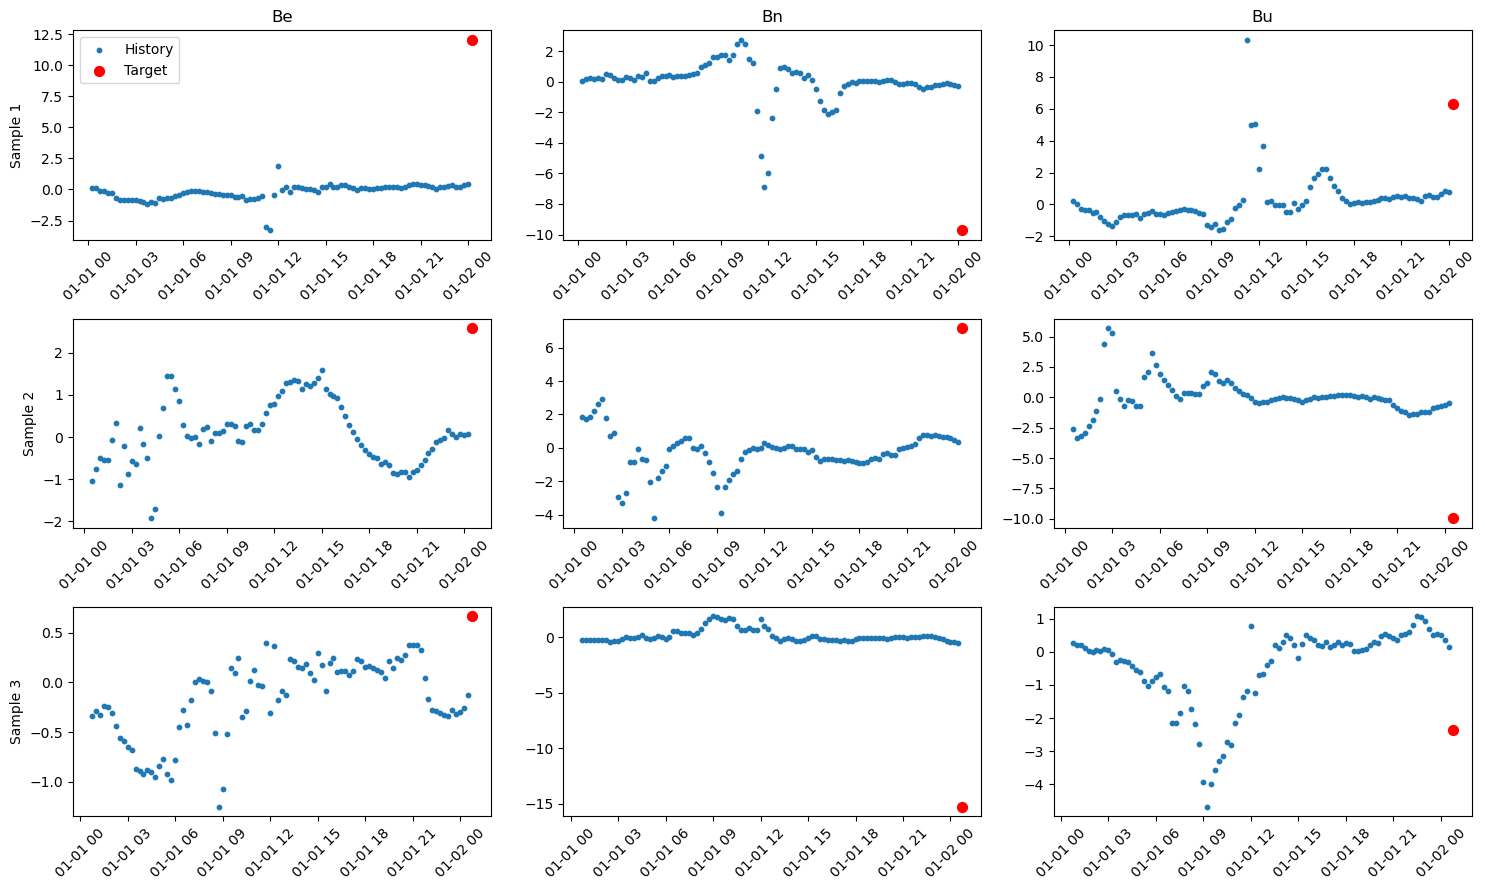

Section 4 complete: batch generator and visualization ready.


In [6]:
# Section 4: Building the Batch Generator & Visualization
# -----------------------------------------------------------------------------
import matplotlib.pyplot as plt
import random

# 4.1. Dataset builder using from_generator to avoid GPU copy errors
def build_tf_dataset(branch1_data, branch2_data, targets, batch_size, shuffle=False):
    def generator():
        for x1, x2, y in zip(branch1_data, branch2_data, targets):
            yield x1.astype(np.float32), x2.astype(np.float32), y.astype(np.float32)

    output_types = (tf.float32, tf.float32, tf.float32)
    output_shapes = (
        tf.TensorShape(branch1_data.shape[1:]),
        tf.TensorShape(branch2_data.shape[1:]),
        tf.TensorShape(targets.shape[1:]),
    )

    ds = tf.data.Dataset.from_generator(
        generator,
        output_types=output_types,
        output_shapes=output_shapes
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=10000, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

# 4.2. Create tf.data.Datasets
train_ds = build_tf_dataset(X1_train, X2_train, y_train, BATCH_SIZE, shuffle=True)
val_ds   = build_tf_dataset(X1_val,   X2_val,   y_val,   BATCH_SIZE, shuffle=False)
test_ds  = build_tf_dataset(X1_test,  X2_test,  y_test,  BATCH_SIZE, shuffle=False)

# 4.3. Inspect one batch
for b1_batch, b2_batch, y_batch in train_ds.take(1):
    print("Branch1 batch:", b1_batch.shape)
    print("Branch2 batch:", b2_batch.shape)
    print("Target batch :", y_batch.shape)

# 4.4. Plot Be, Bn, Bu history & target for 3 random samples
# Pull one batch
for x1_b, x2_b, y_b in train_ds.take(1):
    x1_arr = x1_b.numpy()
    y_arr  = y_b.numpy()
    break
batch_times_end = times_end1[: BATCH_SIZE]
#sample_idxs = random.sample(range(BATCH_SIZE), 3)
sample_idxs = [1, 2, 3]
components = ['Be', 'Bn', 'Bu']
feat_idxs = [16, 17, 18]

fig, axes = plt.subplots(3, 3, figsize=(15, 9))
for i, idx in enumerate(sample_idxs):
    t_end = batch_times_end[idx]
    t_start = times_start1[idx]
    times_series = pd.date_range(start=t_start, end=t_end, periods=BRANCH1_WINDOW_STEPS)
    t_pred = times_target[idx]

    for j, (comp, fidx) in enumerate(zip(components, feat_idxs)):
        ax = axes[i, j]
        ax.scatter(times_series, x1_arr[idx,:,fidx], s=10, label='History' if i==0 else "")
        ax.scatter(t_pred, y_arr[idx, j], s=50, color='red', label='Target' if i==0 else "")
        if i==0: ax.set_title(comp)
        if j==0: ax.set_ylabel(f'Sample {i+1}')
        ax.tick_params(axis='x', rotation=45)
        if i==0 and j==0: ax.legend()
fig.tight_layout()
plt.show()

print("Section 4 complete: batch generator and visualization ready.")
